In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) #makes the display bars longer and spread out 100% across the screen width

In [2]:
from vivarium import Artifact
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from db_queries import get_ids, get_outputs
import scipy.stats

In [3]:
#summer_run1 final


output_dirs =  ['/share/costeffectiveness/results/vivarium_gates_bep/winter_2020/5a/india/2020_12_18_16_23_36/count_data/',
               '/share/costeffectiveness/results/vivarium_gates_bep/winter_2020/5a/pakistan/2020_12_20_16_30_49/count_data/',
               '/share/costeffectiveness/results/vivarium_gates_bep/winter_2020/5a/mali/2020_12_19_10_29_20/count_data/',
               '/share/costeffectiveness/results/vivarium_gates_bep/winter_2020/5a/tanzania/2020_12_19_10_32_34/count_data/']


locations = ['India',
            'Pakistan',
            'Mali',
            'Tanzania']


sorter = ['India','Pakistan','Mali','Tanzania']
sorterIndex = dict(zip(sorter,range(len(sorter))))

!whoami
!date

nicoly
Wed May 19 21:11:03 PDT 2021


In [4]:
# GET LOWER AND UPPER LIMITS

def getLims(df):
    df['lower']=df['mean']-df['2.5%']
    df['upper']=df['97.5%']-df['mean']
    return df


In [5]:
# get model results 

def get_cause_specific_model_results(cause):
    
    master_data = pd.DataFrame()
    
    for i in list(range(len(output_dirs))):
        deaths = pd.read_hdf(output_dirs[i] + 'deaths.hdf')
        deaths = (deaths.where(deaths['scenario'] == 'baseline').dropna() #baseline only
                  .where(deaths['cause'].str.contains(cause)).dropna()
                  .groupby(['input_draw','age_group'], as_index=False).sum() #sum deaths over other columns
                  .rename(columns={'value':'deaths'}))
        
        pt = pd.read_hdf(output_dirs[i] + 'person_time.hdf')
        pt = (pt.where(pt['scenario'] == 'baseline').dropna() #baseline only
              .groupby(['input_draw','age_group'], as_index=False).sum() #sum pt over other columns
              .rename(columns={'value':'person_time'}))
        
        state_pt = pd.read_hdf(output_dirs[i] + 'state_person_time.hdf')
        state_pt = (state_pt.where(state_pt['measure'].str.contains(cause))
                   .where(state_pt['scenario'] == 'baseline').dropna()
                   .groupby(['age_group','measure','input_draw'], as_index=False).sum())
        state_pt = state_pt.groupby(['age_group','measure','input_draw'], as_index=False).sum()
        state_pt = pd.pivot_table(state_pt, index=['input_draw','age_group'], columns='measure',
                              values='value').reset_index()
        state_pt = (state_pt.rename(columns={f'susceptible_to_{cause}_person_time':'susceptible_person_time',
                                           f'{cause}_person_time':'infected_person_time'}))
        if cause == 'measles':
            state_pt = state_pt.drop(columns=f'recovered_from_{cause}_person_time')     

        data = deaths.merge(pt, right_on=['input_draw','age_group'],
                           left_on=['input_draw','age_group'])
        data = data.merge(state_pt, right_on=['input_draw','age_group'],
                             left_on=['input_draw','age_group'])
        
        data['cause_specific_mortality_rate'] = data['deaths'] / data['person_time']
        data['excess_mortality_rate'] = data['deaths'] / data['infected_person_time']
        data['prevalence'] = data['infected_person_time'] / data['person_time'] #unit?? %
        
        if cause in ['measles','meningitis','diarrheal_diseases','lower_respiratory_infections']:
            transition = pd.read_hdf(output_dirs[i] + 'transition_count.hdf')
            transition = (transition.where(transition['measure'].str.contains(cause))
                          .where(transition['scenario'] == 'baseline').dropna())
            transition = (transition.groupby(['age_group','measure','input_draw'], as_index=False).sum())      
            transition = (pd.pivot_table(transition, index=['input_draw','age_group'], columns='measure',
                                      values='value').reset_index()
                          .rename(columns={f'{cause}_to_susceptible_to_{cause}_event_count':'remission_count', #corrected
                                        f'{cause}_to_recovered_from_{cause}_event_count':'remission_count', #corrected
                                        f'susceptible_to_{cause}_to_{cause}_event_count':'incident_count'})) #corrected
            data = data.merge(transition, right_on=['age_group','input_draw'],
                             left_on=['age_group','input_draw'])
            data['incidence_rate'] = data['incident_count'] / data['susceptible_person_time']
            data['remission_rate'] = data['remission_count'] / data['infected_person_time']

        data = data.groupby(['age_group'], as_index=False).mean()
         
        data['location'] = locations[i]
        master_data = master_data.append(data)
    
    master_data['location_rank'] = master_data['location'].map(sorterIndex) #sorting by region 
    master_data = (master_data.sort_values(by='location_rank')
                     .drop(columns=['input_draw','deaths','person_time',
                                    'infected_person_time',
                                   'susceptible_person_time']))#,
                                   #'incident_count','remission_count']))
    return master_data
    
get_cause_specific_model_results('protein_energy_malnutrition')    
  

/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/atom.py:1224: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return pickle.loads(array.tostring())
/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/atom.py:1224: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return pickle.loads(array.tostring())
/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/atom.py:1224: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return pickle.loads(array.tostring())
/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/atom.py:1224: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return pickle.loads(array.tostring())
/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/atom.py:1224: DeprecationWarning: tostring() is deprecated. Use tobytes()

,age_group,cause_specific_mortality_rate,excess_mortality_rate,prevalence,location,location_rank
0,1_to_4,0.000043,0.000275,0.154597,India,0
1,1mo_to_6mo,0.000656,0.003978,0.164900,India,0
2,6mo_to_1,0.000654,0.003997,0.163419,India,0
3,early_neonatal,0.000000,0.000000,0.234020,India,0
4,late_neonatal,0.000000,0.000000,0.238191,India,0
3,early_neonatal,0.000000,0.000000,0.238847,Pakistan,1
2,6mo_to_1,0.000264,0.002629,0.101793,Pakistan,1
4,late_neonatal,0.000000,0.000000,0.143128,Pakistan,1
0,1_to_4,0.000053,0.000423,0.125442,Pakistan,1
1,1mo_to_6mo,0.000278,0.002758,0.103117,Pakistan,1


In [6]:
# define function to load data from artifact for a specified cause and measure
# this function is called in the next function below

def load_artifact_data(cause, measure):
    master_art_data = pd.DataFrame()
    for i in ['india','pakistan','mali','tanzania']:
        art = Artifact('/share/costeffectiveness/artifacts/vivarium_gates_bep/' + i + '.hdf', 
                   filter_terms=['year_start == 2017', 'age_start < 5'])
        data = art.load('cause.' + cause + '.' + measure)
        data = pd.DataFrame(data.mean(axis=1)).reset_index().rename(columns={0:'value'})
        data['location'] = i.capitalize()
        data['measure'] = measure
        data['age_group'] = 0
        data['age_group'] = np.where(data['age_start'] == 0, 'early_neonatal', 
                                   np.where(data['age_end'] == 1, '1mo_to_6mo',
                                            np.where(data['age_start'] == 1, '1_to_4', 
                                                    'late_neonatal')))
        master_art_data = master_art_data.append(data)
        
    return master_art_data

In [10]:
art = Artifact('/share/costeffectiveness/artifacts/vivarium_gates_bep/india.hdf', filter_terms=['year_start == 2017', 'age_start < 5'])
art.keys

['metadata.keyspace',
 'metadata.locations',
 'population.structure',
 'population.age_bins',
 'population.demographic_dimensions',
 'population.theoretical_minimum_risk_life_expectancy',
 'cause.all_causes.cause_specific_mortality_rate',
 'covariate.live_births_by_sex.estimate',
 'covariate.antenatal_care_1_visit_coverage_proportion.estimate',
 'cause.diarrheal_diseases.prevalence',
 'cause.diarrheal_diseases.incidence_rate',
 'cause.diarrheal_diseases.remission_rate',
 'cause.diarrheal_diseases.cause_specific_mortality_rate',
 'cause.diarrheal_diseases.excess_mortality_rate',
 'cause.diarrheal_diseases.disability_weight',
 'cause.diarrheal_diseases.restrictions',
 'cause.measles.prevalence',
 'cause.measles.incidence_rate',
 'cause.measles.cause_specific_mortality_rate',
 'cause.measles.excess_mortality_rate',
 'cause.measles.disability_weight',
 'cause.measles.restrictions',
 'cause.lower_respiratory_infections.prevalence',
 'cause.lower_respiratory_infections.birth_prevalence',
 'c

In [11]:
# define function to get artifact data for all locations, causes, measures

def get_cause_specific_artifact_data(cause):
    master_art = pd.DataFrame()
    if cause == 'measles':
        for measure in ['prevalence','incidence_rate',
                  'cause_specific_mortality_rate','excess_mortality_rate']:
            data = load_artifact_data(cause, measure)
            master_art = master_art.append(data)
    elif cause in 'protein_energy_malnutrition':
        for measure in ['cause_specific_mortality_rate','excess_mortality_rate']:
            data = load_artifact_data(cause, measure)
            master_art = master_art.append(data)
    else:
        for measure in ['prevalence','incidence_rate','remission_rate',
                      'cause_specific_mortality_rate','excess_mortality_rate']:
            data = load_artifact_data(cause, measure)
            master_art = master_art.append(data)
    master_art = master_art.drop(columns=['age_start','age_end','year_start','year_end'])
    master_art_avg = master_art.groupby(['location','measure','age_group'], as_index=False).mean()
    master_art_avg = pd.pivot_table(master_art_avg, index=['location','age_group'],
                     columns=['measure'], values='value').reset_index()
    
    master_art_avg['location_rank'] = master_art_avg['location'].map(sorterIndex) #sorting by region
    master_art_avg = master_art_avg.sort_values(by='location_rank')
    
    return master_art_avg
    
get_cause_specific_artifact_data('measles')   
                   

/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/nodes/filenode.py:258: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  b[:n] = self._node.read(start, stop).tostring()
/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/nodes/filenode.py:258: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  b[:n] = self._node.read(start, stop).tostring()
/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/nodes/filenode.py:258: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  b[:n] = self._node.read(start, stop).tostring()
/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/nodes/filenode.py:258: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  b[:n] = self._node.read(start, stop).tostring()
/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tabl

measure,location,age_group,cause_specific_mortality_rate,excess_mortality_rate,incidence_rate,prevalence,location_rank
0,India,1_to_4,0.000105,0.068988,0.056667,0.001550,0
1,India,1mo_to_6mo,0.000243,0.099423,0.090331,0.002467,0
2,India,early_neonatal,0.000000,0.000000,0.000000,0.000000,0
3,India,late_neonatal,0.000000,0.000000,0.000000,0.000000,0
8,Pakistan,1_to_4,0.000050,0.259045,0.007036,0.000193,1
9,Pakistan,1mo_to_6mo,0.000093,0.304956,0.011186,0.000306,1
10,Pakistan,early_neonatal,0.000000,0.000000,0.000000,0.000000,1
11,Pakistan,late_neonatal,0.000000,0.000000,0.000000,0.000000,1
4,Mali,1_to_4,0.000380,0.812981,0.017222,0.000472,2
5,Mali,1mo_to_6mo,0.000479,0.642724,0.027385,0.000750,2


In [12]:
# define function that will make plots for each measure for a specific cause

def make_and_save_plots(cause, model_data, artifact_data, title, acronym):
    #CSMR
    barWidth = 0.3
    #fig,axs = plt.subplots(2,2)
    fig,axs = plt.subplots(2,2,figsize=(16,14)) #width, height
    
    model = model_data['cause_specific_mortality_rate'].where(model_data['age_group'] == 'early_neonatal').dropna()
    gbd = artifact_data['cause_specific_mortality_rate'].where(artifact_data['age_group'] == 'early_neonatal').dropna()
    a = np.arange(len(model))
    b = [x + barWidth for x in a]
    axs[0,0].bar(a, gbd, width=barWidth)
    axs[0,0].bar(b, model, width=barWidth)
    axs[0,0].set_title('Early Neonatal')
    
    model = model_data['cause_specific_mortality_rate'].where(model_data['age_group'] == 'late_neonatal').dropna()
    gbd = artifact_data['cause_specific_mortality_rate'].where(artifact_data['age_group'] == 'late_neonatal').dropna()
    a = np.arange(len(model))
    b = [x + barWidth for x in a]
    axs[0,1].bar(a, gbd, width=barWidth)
    axs[0,1].bar(b, model, width=barWidth)
    axs[0,1].set_title('Late Neonatal')
    
    model = model_data['cause_specific_mortality_rate'].where(model_data['age_group'] == '1mo_to_6mo').dropna()
    gbd = artifact_data['cause_specific_mortality_rate'].where(artifact_data['age_group'] == '1mo_to_6mo').dropna()
    a = np.arange(len(model))
    b = [x + barWidth for x in a]
    axs[1,0].bar(a, gbd, width=barWidth)
    axs[1,0].bar(b, model, width=barWidth)
    axs[1,0].set_title('1 Month to 1 Year')
    
    model = model_data['cause_specific_mortality_rate'].where(model_data['age_group'] == '1_to_4').dropna()
    gbd = artifact_data['cause_specific_mortality_rate'].where(artifact_data['age_group'] == '1_to_4').dropna()
    a = np.arange(len(model))
    b = [x + barWidth for x in a]
    axs[1,1].bar(a, gbd, width=barWidth)
    axs[1,1].bar(b, model, width=barWidth)
    axs[1,1].set_title('1-4 Years')
    
    plt.setp(axs, xticks=[r + barWidth for r in range(len(model))], 
             xticklabels=np.unique(model_data['location'])[[0, 2, 1, 3]])
    for ax in axs.flat:
        ax.set(ylabel='CSMR')
    plt.legend(['GBD 2017 Input','Model Output'])
    plt.suptitle(f'{title} Cause-Specific Mortality Rate',x=0.55, y=1)
    plt.subplots_adjust(right=1.7, top=1.5)
    plt.tight_layout()
    plt.savefig(f'{acronym}_csmr')
    
    #EMR
    barWidth = 0.3
    fig,axs = plt.subplots(2,2,figsize=(10,8)) #width, height
    
    model = model_data['excess_mortality_rate'].where(model_data['age_group'] == 'early_neonatal').dropna()
    gbd = artifact_data['excess_mortality_rate'].where(artifact_data['age_group'] == 'early_neonatal').dropna()
    a = np.arange(len(model))
    b = [x + barWidth for x in a]
    axs[0,0].bar(a, gbd, width=barWidth)
    axs[0,0].bar(b, model, width=barWidth)
    axs[0,0].set_title('Early Neonatal')
    
    model = model_data['excess_mortality_rate'].where(model_data['age_group'] == 'late_neonatal').dropna()
    gbd = artifact_data['excess_mortality_rate'].where(artifact_data['age_group'] == 'late_neonatal').dropna()
    a = np.arange(len(model))
    b = [x + barWidth for x in a]
    axs[0,1].bar(a, gbd, width=barWidth)
    axs[0,1].bar(b, model, width=barWidth)
    axs[0,1].set_title('Late Neonatal')
    
    model = model_data['excess_mortality_rate'].where(model_data['age_group'] == '1mo_to_6mo').dropna()
    gbd = artifact_data['excess_mortality_rate'].where(artifact_data['age_group'] == '1mo_to_6mo').dropna()
    a = np.arange(len(model))
    b = [x + barWidth for x in a]
    axs[1,0].bar(a, gbd, width=barWidth)
    axs[1,0].bar(b, model, width=barWidth)
    axs[1,0].set_title('1 Month to 1 Year')
    
    model = model_data['excess_mortality_rate'].where(model_data['age_group'] == '1_to_4').dropna()
    gbd = artifact_data['excess_mortality_rate'].where(artifact_data['age_group'] == '1_to_4').dropna()
    a = np.arange(len(model))
    b = [x + barWidth for x in a]
    axs[1,1].bar(a, gbd, width=barWidth)
    axs[1,1].bar(b, model, width=barWidth)
    axs[1,1].set_title('1-4 Years')
    
    plt.setp(axs, xticks=[r + barWidth for r in range(len(model))], 
             xticklabels=np.unique(model_data['location'])[[0, 2, 1, 3]])
    for ax in axs.flat:
        ax.set(ylabel='EMR')
    plt.legend(['GBD 2017 Input','Model Output'])
    plt.suptitle(f'{title} Excess Mortality Rate',x=0.55, y=1)
    plt.subplots_adjust(right=1.7, top=1.5)
    plt.tight_layout()
    plt.savefig(f'{acronym}_emr')
   

    if cause in ['lower_respiratory_infections','diarrheal_diseases',
                 'measles','meningitis']:
        # Prevalence
        barWidth = 0.3
        fig,axs = plt.subplots(2,2,figsize=(10,8)) #width, height
        
        model = model_data['prevalence'].where(model_data['age_group'] == 'early_neonatal').dropna()
        gbd = artifact_data['prevalence'].where(artifact_data['age_group'] == 'early_neonatal').dropna()
        a = np.arange(len(model))
        b = [x + barWidth for x in a]
        axs[0,0].bar(a, gbd, width=barWidth)
        axs[0,0].bar(b, model, width=barWidth)
        axs[0,0].set_title('Early Neonatal')
        
        model = model_data['prevalence'].where(model_data['age_group'] == 'late_neonatal').dropna()
        gbd = artifact_data['prevalence'].where(artifact_data['age_group'] == 'late_neonatal').dropna()
        a = np.arange(len(model))
        b = [x + barWidth for x in a]
        axs[0,1].bar(a, gbd, width=barWidth)
        axs[0,1].bar(b, model, width=barWidth)
        axs[0,1].set_title('Late Neonatal')
        
        model = model_data['prevalence'].where(model_data['age_group'] == '1mo_to_6mo').dropna()
        gbd = artifact_data['prevalence'].where(artifact_data['age_group'] == '1mo_to_6mo').dropna()
        a = np.arange(len(model))
        b = [x + barWidth for x in a]
        axs[1,0].bar(a, gbd, width=barWidth)
        axs[1,0].bar(b, model, width=barWidth)
        axs[1,0].set_title('1 Month to 1 Year')
        
        model = model_data['prevalence'].where(model_data['age_group'] == '1_to_4').dropna()
        gbd = artifact_data['prevalence'].where(artifact_data['age_group'] == '1_to_4').dropna()
        a = np.arange(len(model))
        b = [x + barWidth for x in a]
        axs[1,1].bar(a, gbd, width=barWidth)
        axs[1,1].bar(b, model, width=barWidth)
        axs[1,1].set_title('1-4 Years')
        plt.setp(axs, xticks=[r + barWidth for r in range(len(model))], 
                 xticklabels=np.unique(model_data['location'])[[0, 2, 1, 3]])
        
        for ax in axs.flat:
            ax.set(ylabel='Proportion')
        plt.legend(['GBD 2017 Input','Model Output'])
        plt.suptitle(f'{title} Prevalence',x=0.55, y=1)
        plt.subplots_adjust(right=1.7, top=1.5)
        plt.tight_layout()
        plt.savefig(f'{acronym}_prevalence')
        
    if cause in ['lower_respiratory_infections','diarrheal_diseases','measles','meningitis']:
        # Incidence
        barWidth = 0.3
        fig,axs = plt.subplots(2,2,figsize=(10,8)) #width, height
        
        model = model_data['incidence_rate'].where(model_data['age_group'] == 'early_neonatal').dropna()
        gbd = artifact_data['incidence_rate'].where(artifact_data['age_group'] == 'early_neonatal').dropna()
        a = np.arange(len(model))
        b = [x + barWidth for x in a]
        axs[0,0].bar(a, gbd, width=barWidth)
        axs[0,0].bar(b, model, width=barWidth)
        axs[0,0].set_title('Early Neonatal')
        
        model = model_data['incidence_rate'].where(model_data['age_group'] == 'late_neonatal').dropna()
        gbd = artifact_data['incidence_rate'].where(artifact_data['age_group'] == 'late_neonatal').dropna()
        a = np.arange(len(model))
        b = [x + barWidth for x in a]
        axs[0,1].bar(a, gbd, width=barWidth)
        axs[0,1].bar(b, model, width=barWidth)
        axs[0,1].set_title('Late Neonatal')
        
        model = model_data['incidence_rate'].where(model_data['age_group'] == '1mo_to_6mo').dropna()
        gbd = artifact_data['incidence_rate'].where(artifact_data['age_group'] == '1mo_to_6mo').dropna()
        a = np.arange(len(model))
        b = [x + barWidth for x in a]
        axs[1,0].bar(a, gbd, width=barWidth)
        axs[1,0].bar(b, model, width=barWidth)
        axs[1,0].set_title('1 Month to 1 Year')
        
        model = model_data['incidence_rate'].where(model_data['age_group'] == '1_to_4').dropna()
        gbd = artifact_data['incidence_rate'].where(artifact_data['age_group'] == '1_to_4').dropna()
        a = np.arange(len(model))
        b = [x + barWidth for x in a]
        axs[1,1].bar(a, gbd, width=barWidth)
        axs[1,1].bar(b, model, width=barWidth)
        axs[1,1].set_title('1-4 Years')
        
        plt.setp(axs, xticks=[r + barWidth for r in range(len(model))], 
                 xticklabels=np.unique(model_data['location'])[[0, 2, 1, 3]])
        for ax in axs.flat:
            ax.set(ylabel='Incidence Rate')
        plt.legend(['GBD 2017 Input','Model Output'])
        plt.suptitle(f'{title} Incidence Rate',x=0.55, y=1)
        plt.subplots_adjust(right=1.7, top=1.5)
        plt.tight_layout()
        plt.savefig(f'{acronym}_incidence')
        
        # Remission
        barWidth = 0.3
        fig,axs = plt.subplots(2,2,figsize=(10,8)) #width, height
        
        model = model_data['remission_rate'].where(model_data['age_group'] == 'early_neonatal').dropna()
        gbd = artifact_data['remission_rate'].where(artifact_data['age_group'] == 'early_neonatal').dropna()
        a = np.arange(len(model))
        b = [x + barWidth for x in a]
        axs[0,0].bar(a, gbd, width=barWidth)
        axs[0,0].bar(b, model, width=barWidth)
        axs[0,0].set_title('Early Neonatal')
        
        model = model_data['remission_rate'].where(model_data['age_group'] == 'late_neonatal').dropna()
        gbd = artifact_data['remission_rate'].where(artifact_data['age_group'] == 'late_neonatal').dropna()
        a = np.arange(len(model))
        b = [x + barWidth for x in a]
        axs[0,1].bar(a, gbd, width=barWidth)
        axs[0,1].bar(b, model, width=barWidth)
        axs[0,1].set_title('Late Neonatal')
        
        model = model_data['remission_rate'].where(model_data['age_group'] == '1mo_to_6mo').dropna()
        gbd = artifact_data['remission_rate'].where(artifact_data['age_group'] == '1mo_to_6mo').dropna()
        a = np.arange(len(model))
        b = [x + barWidth for x in a]
        axs[1,0].bar(a, gbd, width=barWidth)
        axs[1,0].bar(b, model, width=barWidth)
        axs[1,0].set_title('1 Month to 1 Year')
        
        model = model_data['remission_rate'].where(model_data['age_group'] == '1_to_4').dropna()
        gbd = artifact_data['remission_rate'].where(artifact_data['age_group'] == '1_to_4').dropna()
        a = np.arange(len(model))
        b = [x + barWidth for x in a]
        axs[1,1].bar(a, gbd, width=barWidth)
        axs[1,1].bar(b, model, width=barWidth)
        axs[1,1].set_title('1-4 Years')
        
        # Overall Format
        plt.setp(axs, xticks=[r + barWidth for r in range(len(model))], 
                 xticklabels=np.unique(model_data['location'])[[0, 2, 1, 3]])
        
        for ax in axs.flat:
            ax.set(ylabel='Remission Rate')
        
        plt.legend(['GBD 2017 Input','Model Output'])
        plt.suptitle(f'{title} Remission Rate',x=0.55, y=1)
        plt.subplots_adjust(right=1.7, top=1.5)
        plt.tight_layout()
        plt.savefig(f'{acronym}_remission')

In [14]:
measles_artifact = get_cause_specific_artifact_data('measles')
measles_artifact

/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/nodes/filenode.py:258: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  b[:n] = self._node.read(start, stop).tostring()
/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/nodes/filenode.py:258: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  b[:n] = self._node.read(start, stop).tostring()
/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/nodes/filenode.py:258: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  b[:n] = self._node.read(start, stop).tostring()
/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/nodes/filenode.py:258: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  b[:n] = self._node.read(start, stop).tostring()
/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tabl

measure,location,age_group,cause_specific_mortality_rate,excess_mortality_rate,incidence_rate,prevalence,location_rank
0,India,1_to_4,0.000105,0.068988,0.056667,0.001550,0
1,India,1mo_to_6mo,0.000243,0.099423,0.090331,0.002467,0
2,India,early_neonatal,0.000000,0.000000,0.000000,0.000000,0
3,India,late_neonatal,0.000000,0.000000,0.000000,0.000000,0
8,Pakistan,1_to_4,0.000050,0.259045,0.007036,0.000193,1
9,Pakistan,1mo_to_6mo,0.000093,0.304956,0.011186,0.000306,1
10,Pakistan,early_neonatal,0.000000,0.000000,0.000000,0.000000,1
11,Pakistan,late_neonatal,0.000000,0.000000,0.000000,0.000000,1
4,Mali,1_to_4,0.000380,0.812981,0.017222,0.000472,2
5,Mali,1mo_to_6mo,0.000479,0.642724,0.027385,0.000750,2


# measles remission rate

In [16]:
measles_artifact['remission_rate'] = np.where(measles_artifact['age_group'] == 'early_neonatal',0,36.5)
measles_artifact['remission_rate'] = np.where(measles_artifact['age_group'] == 'late_neonatal',0,measles_artifact['remission_rate'])
measles_artifact

measure,location,age_group,cause_specific_mortality_rate,excess_mortality_rate,incidence_rate,prevalence,location_rank,remission_rate
0,India,1_to_4,0.000105,0.068988,0.056667,0.001550,0,36.5
1,India,1mo_to_6mo,0.000243,0.099423,0.090331,0.002467,0,36.5
2,India,early_neonatal,0.000000,0.000000,0.000000,0.000000,0,0.0
3,India,late_neonatal,0.000000,0.000000,0.000000,0.000000,0,0.0
8,Pakistan,1_to_4,0.000050,0.259045,0.007036,0.000193,1,36.5
9,Pakistan,1mo_to_6mo,0.000093,0.304956,0.011186,0.000306,1,36.5
10,Pakistan,early_neonatal,0.000000,0.000000,0.000000,0.000000,1,0.0
11,Pakistan,late_neonatal,0.000000,0.000000,0.000000,0.000000,1,0.0
4,Mali,1_to_4,0.000380,0.812981,0.017222,0.000472,2,36.5
5,Mali,1mo_to_6mo,0.000479,0.642724,0.027385,0.000750,2,36.5


In [18]:
# call the functions that we defined above to load the data for models (_model)
# and artifacts (_artifact) for each cause (these datasets will have data for all locations)

pem_model = get_cause_specific_model_results('protein_energy_malnutrition')
pem_artifact = get_cause_specific_artifact_data('protein_energy_malnutrition')

lri_model = get_cause_specific_model_results('lower_respiratory_infections')
lri_artifact = get_cause_specific_artifact_data('lower_respiratory_infections')

dd_model = get_cause_specific_model_results('diarrheal_diseases')
dd_artifact = get_cause_specific_artifact_data('diarrheal_diseases')

measles_model = get_cause_specific_model_results('measles')
measles_artifact = get_cause_specific_artifact_data('measles')

# measles is a little different than the other causes because it is an SIR cause model
# instead of an SIS cause model, so I fixed a couple things after the fact
measles_model = measles_model.fillna(0)
measles_artifact['remission_rate'] = np.where(measles_artifact['age_group'] == 'early_neonatal',0,36.5)
measles_artifact['remission_rate'] = np.where(measles_artifact['age_group'] == 'late_neonatal',0,measles_artifact['remission_rate'])

/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/atom.py:1224: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return pickle.loads(array.tostring())
/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/atom.py:1224: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return pickle.loads(array.tostring())
/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/atom.py:1224: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return pickle.loads(array.tostring())
/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/atom.py:1224: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return pickle.loads(array.tostring())
/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/atom.py:1224: DeprecationWarning: tostring() is deprecated. Use tobytes()

/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/nodes/filenode.py:258: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  b[:n] = self._node.read(start, stop).tostring()
/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/nodes/filenode.py:258: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  b[:n] = self._node.read(start, stop).tostring()
/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/nodes/filenode.py:258: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  b[:n] = self._node.read(start, stop).tostring()
/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/nodes/filenode.py:258: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  b[:n] = self._node.read(start, stop).tostring()
/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tabl

/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/nodes/filenode.py:258: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  b[:n] = self._node.read(start, stop).tostring()
/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/nodes/filenode.py:258: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  b[:n] = self._node.read(start, stop).tostring()
/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/nodes/filenode.py:258: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  b[:n] = self._node.read(start, stop).tostring()
/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/nodes/filenode.py:258: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  b[:n] = self._node.read(start, stop).tostring()
/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tabl

/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/nodes/filenode.py:258: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  b[:n] = self._node.read(start, stop).tostring()
/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/nodes/filenode.py:258: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  b[:n] = self._node.read(start, stop).tostring()
/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/nodes/filenode.py:258: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  b[:n] = self._node.read(start, stop).tostring()
/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/nodes/filenode.py:258: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  b[:n] = self._node.read(start, stop).tostring()
/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tabl

In [ ]:
get_cause_specific_artifact_data('measles')

In [ ]:
measles_artifact

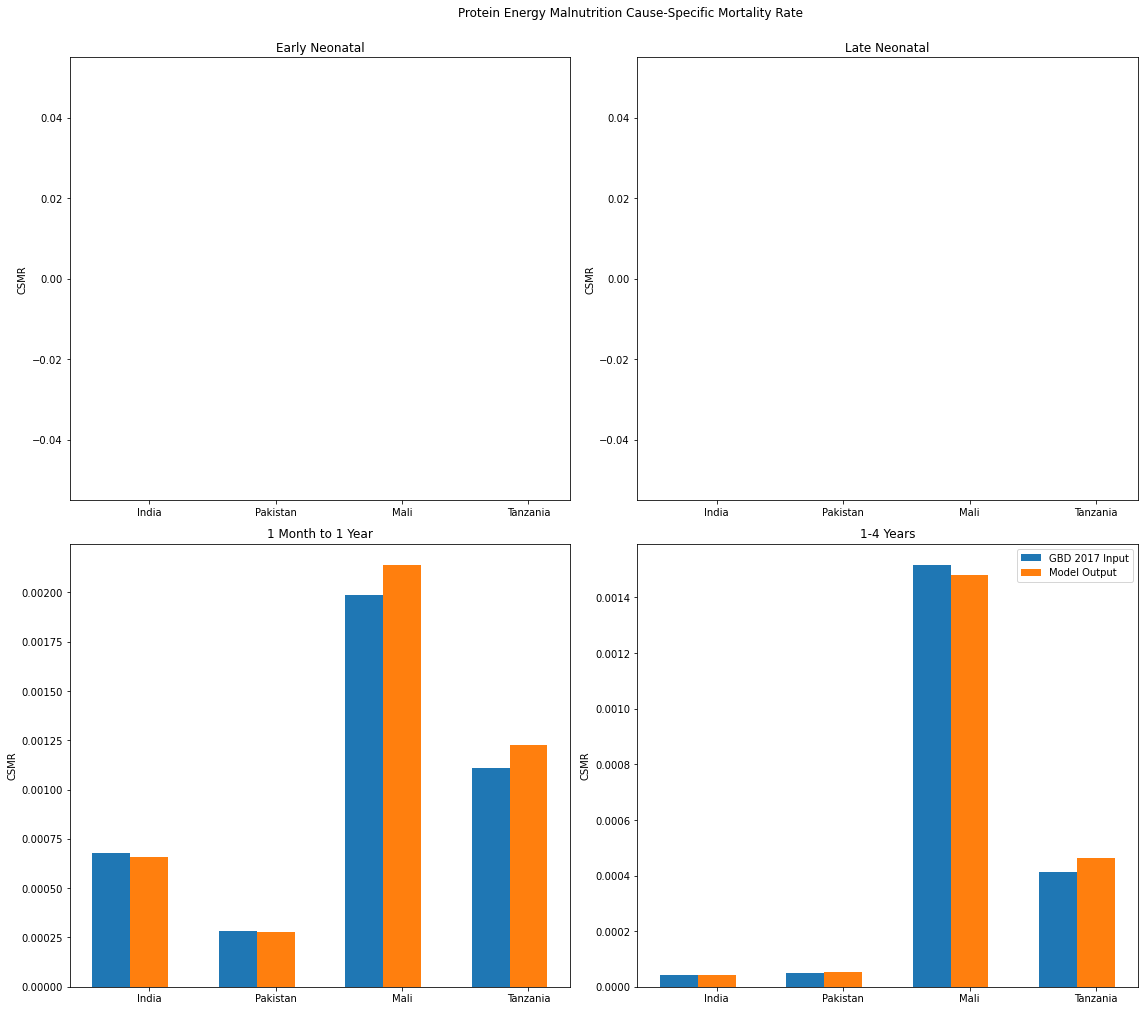

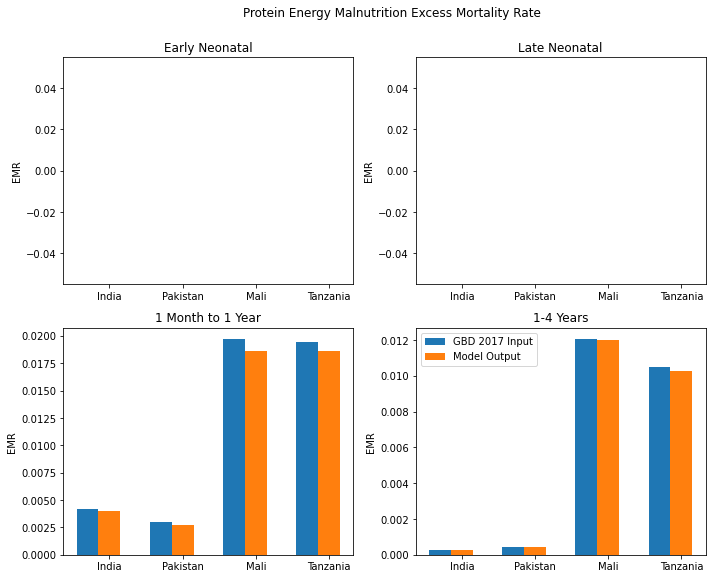

In [19]:
make_and_save_plots('protein_energy_malnutrition', pem_model, pem_artifact, 'Protein Energy Malnutrition', 'pem')

In [ ]:
pem_model

In [ ]:
pem_artifact

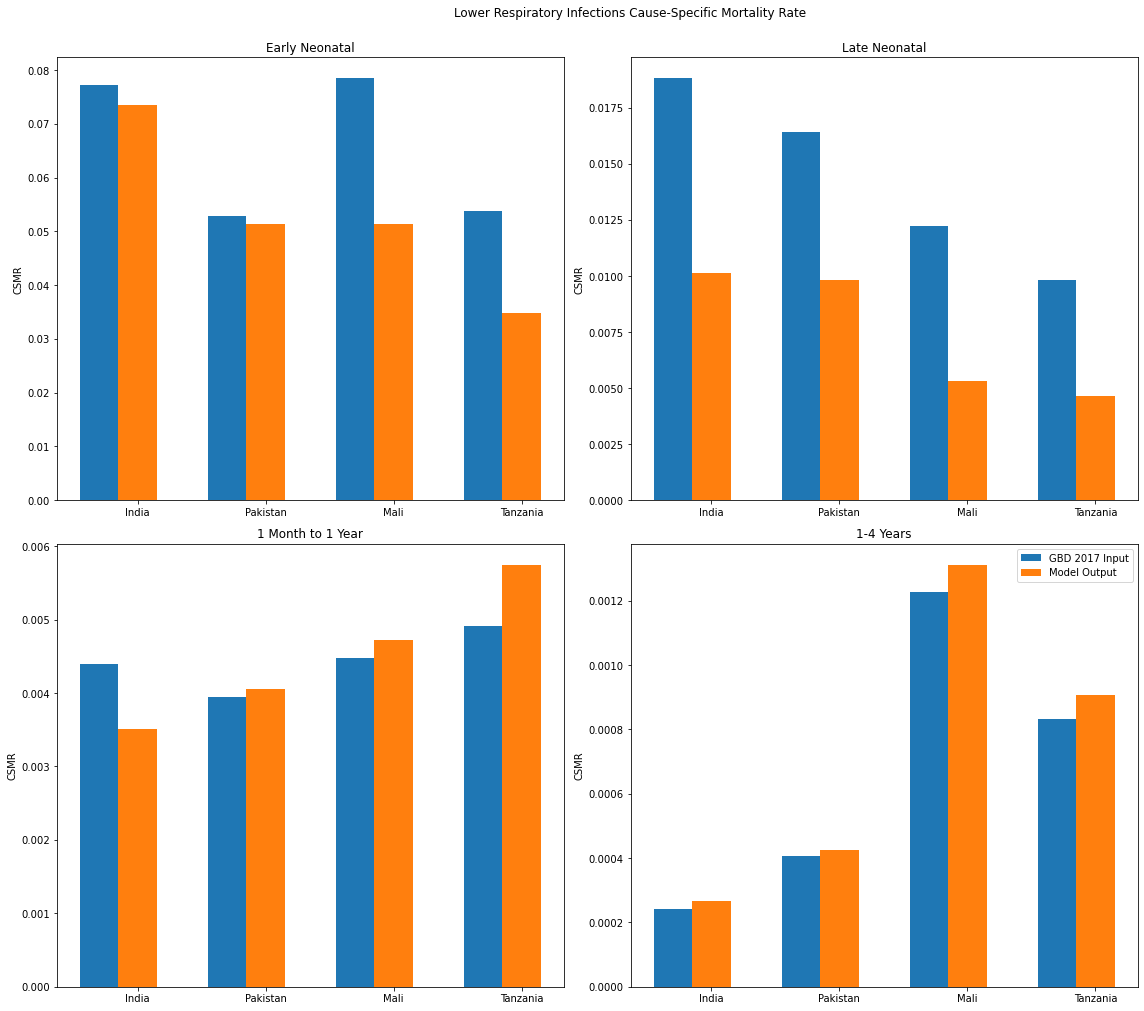

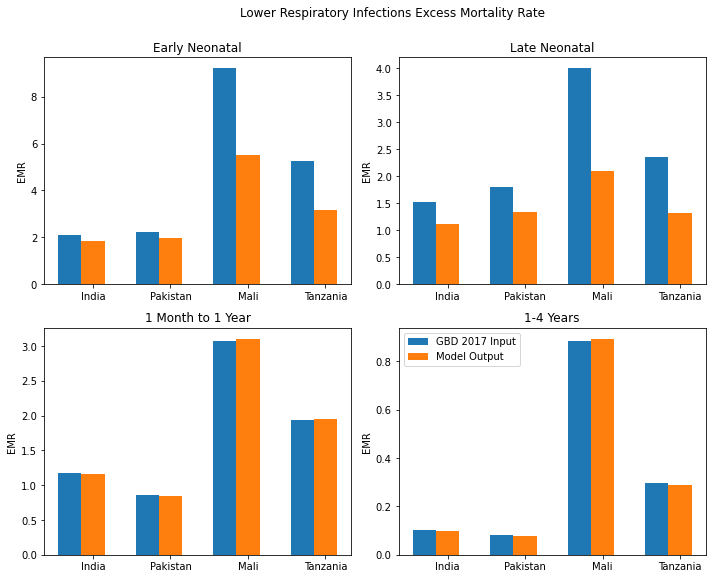

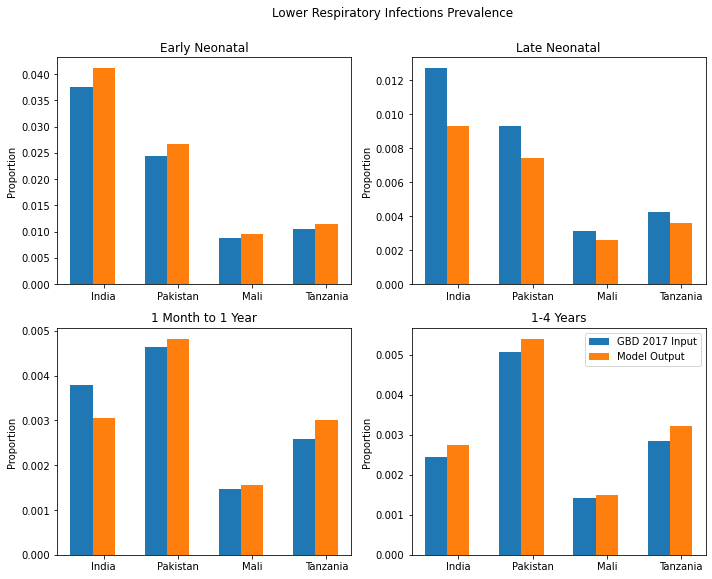

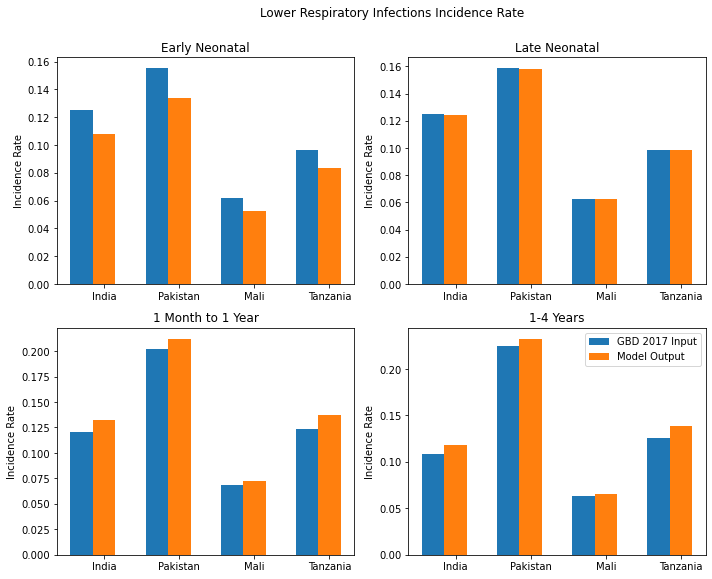

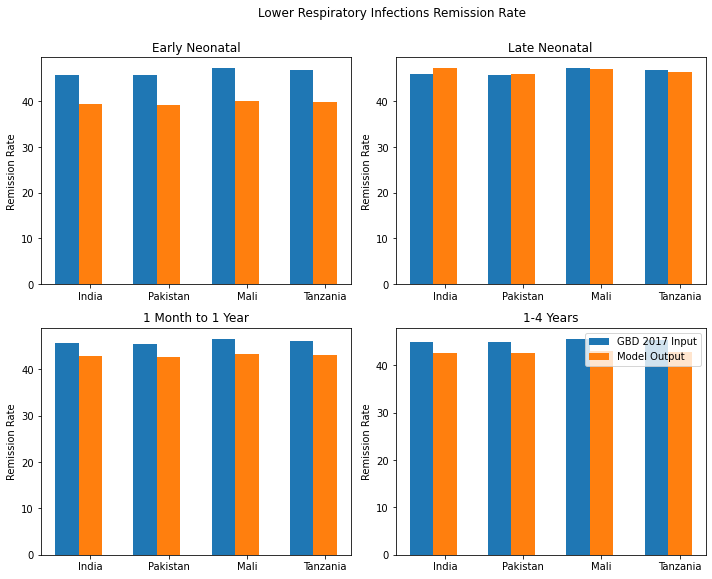

In [20]:
make_and_save_plots('lower_respiratory_infections', lri_model, lri_artifact, 'Lower Respiratory Infections', 'lri')

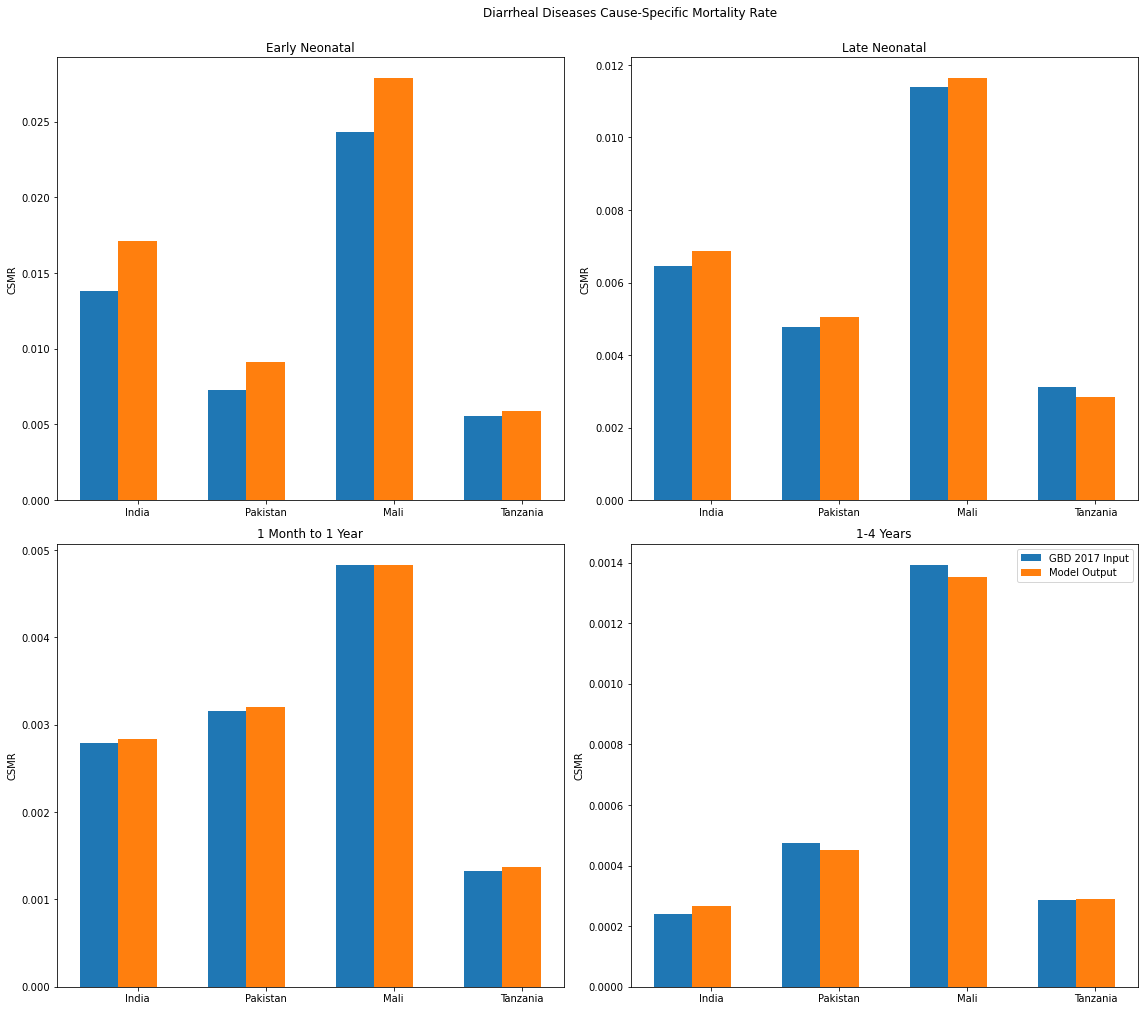

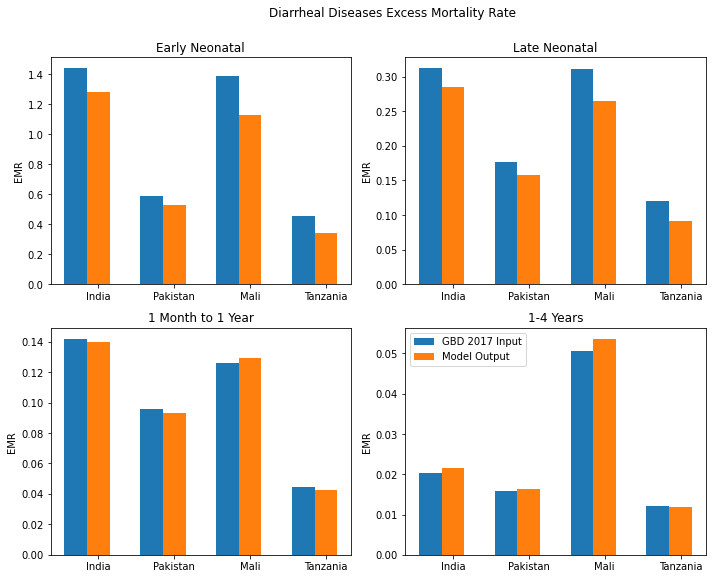

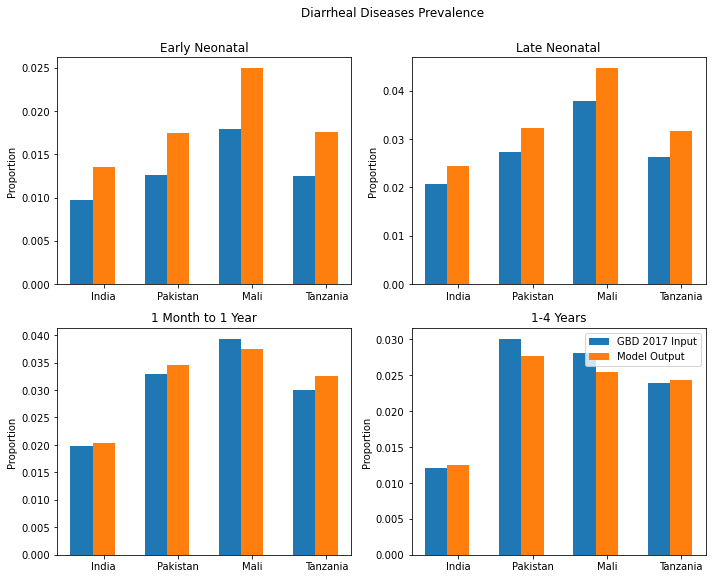

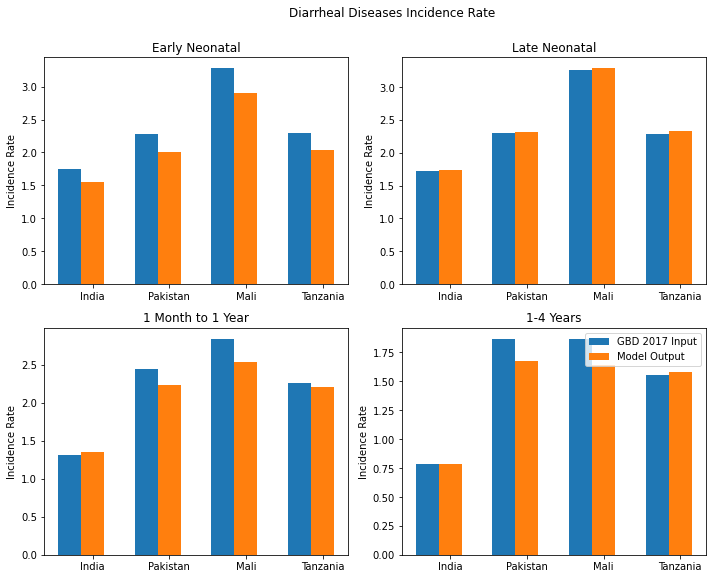

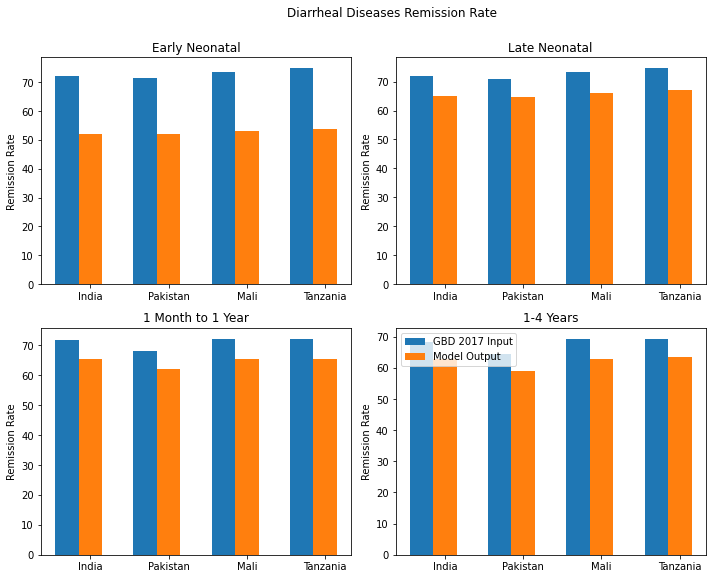

In [21]:
make_and_save_plots('diarrheal_diseases', dd_model, dd_artifact, 'Diarrheal Diseases', 'dd')

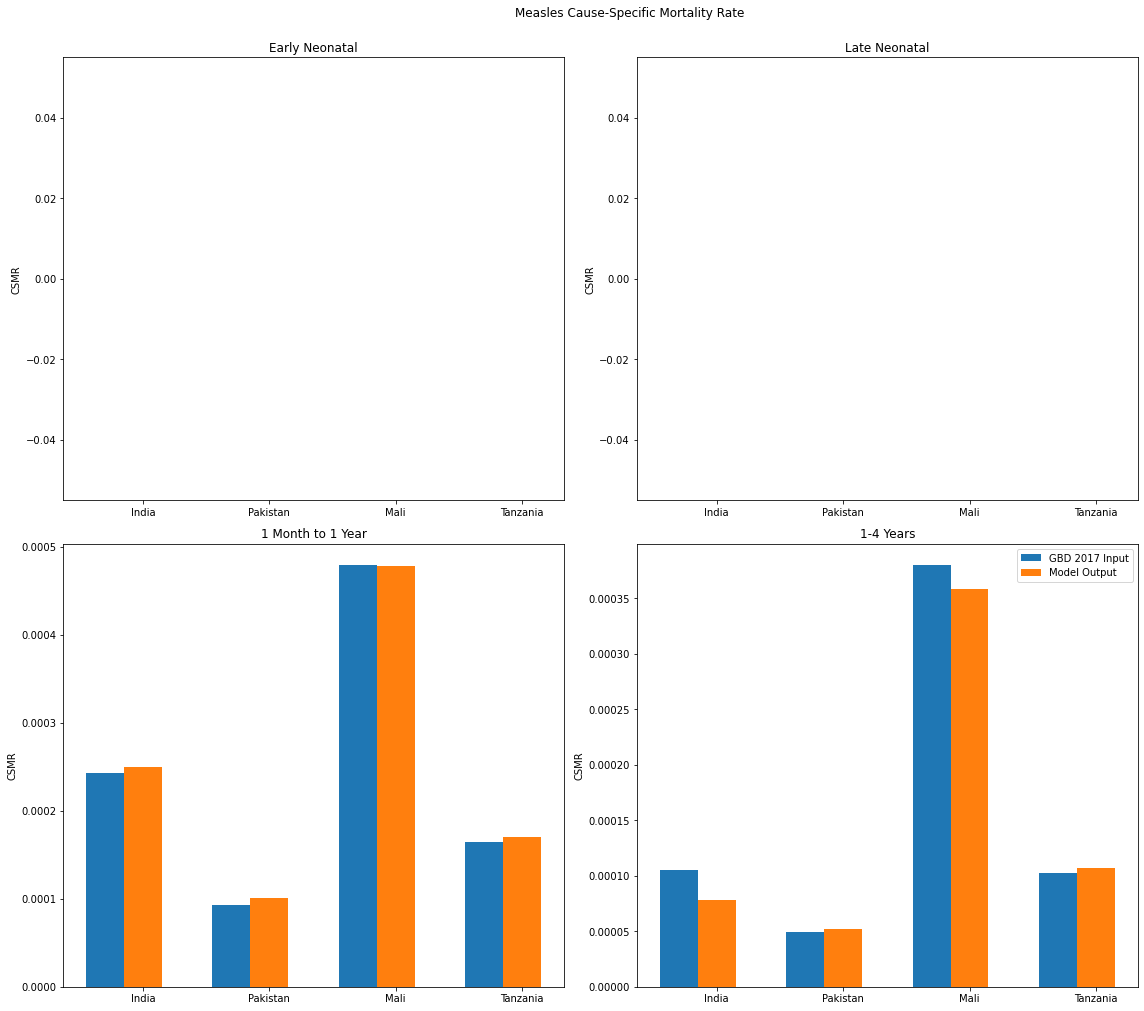

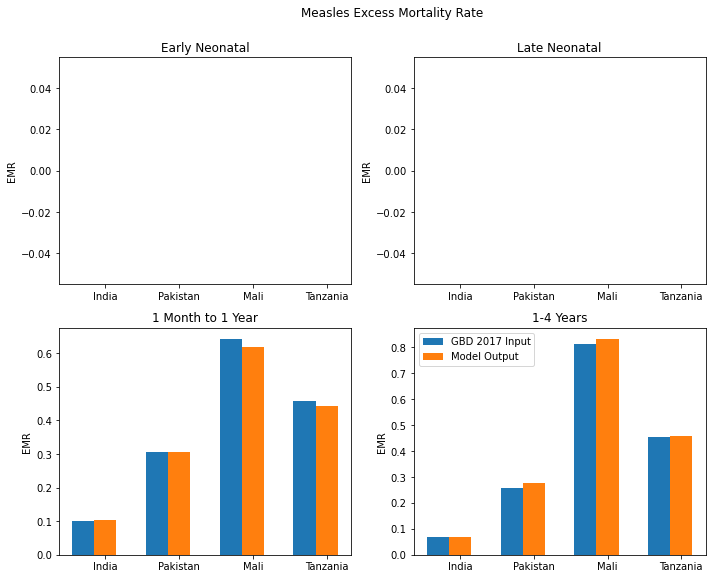

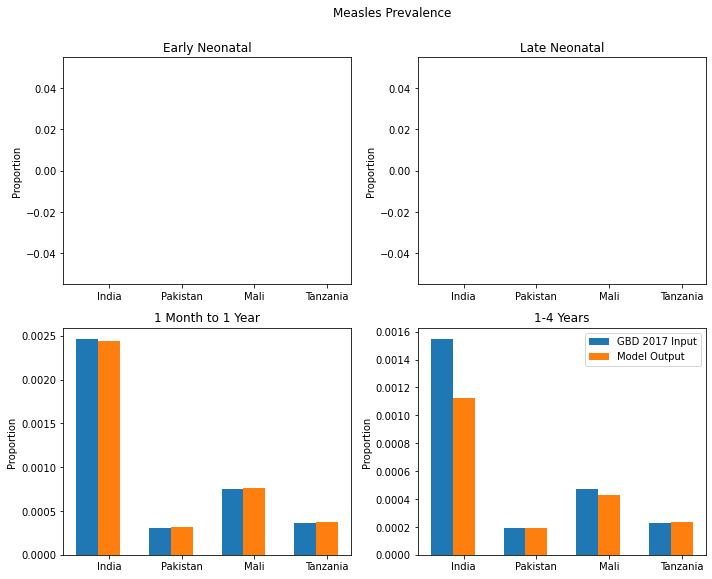

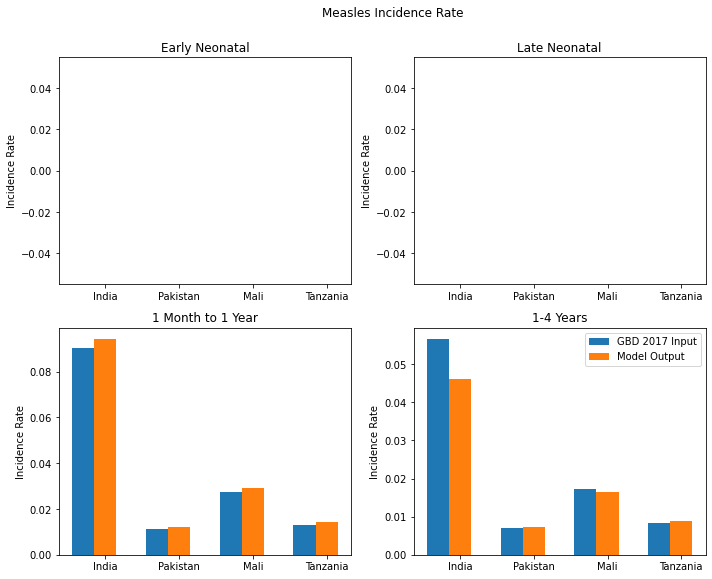

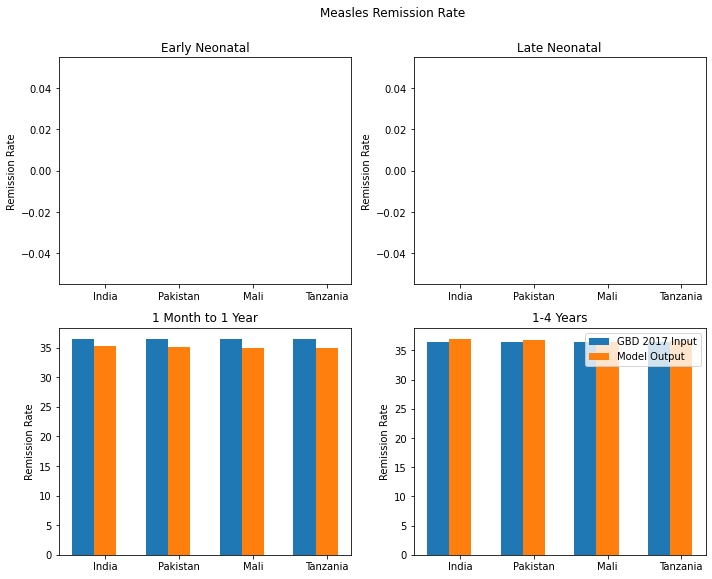

In [22]:
make_and_save_plots('measles', measles_model, measles_artifact, 'Measles', 'measles')